In [7]:
# import a custom plotting library
import some_plotters as plotter

# import autograd functionality
import autograd.numpy as np

# import path to datasets
datapath = 'datasets/'

# # this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
# from matplotlib import rcParams
# rcParams['figure.autolayout'] = True
# %matplotlib notebook

# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

#Imports
from autograd.misc.flatten import flatten_func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### <span style="color:#a50e3e;">Exercise 1: </span>  Train an unregularized PID controller for the cruise control problem

In this exercise you will tune the parameters of a PID controller automatically so that the trained Imitation Model (that you trained in homework 1 exercise 1) matches the example set point sequence shown below relatively closely.  

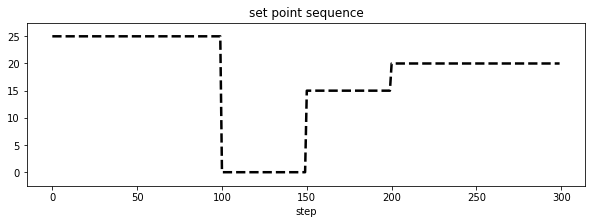

In [8]:
# load in set point sequence
csvname = 'datasets/cruise_setpoints.csv'
set_points = np.loadtxt(csvname,delimiter = ',')[np.newaxis,:]

# plot set point sequence
plotter.plot_setpoints(set_points)

Implement a `Pythonic` version of the PID controller Least Squares cost function discussed in the [course notes](https://jermwatt.github.io/control-notes/presentations/pid_control/pid_control_part_1.slides.html#/).  You should be able to learn an optimal action / state sequence pair so that your system model responds fairly well to the input set point sequence.  The image below shows the results of an action/state sequence pair learned by a fully tuned PID controller.  The top panel shows the set point sequence in dashed black, with the state sequence defined by the controller in blue.  The bottom panel shows the corresponding action sequence defined by the controller.

<figure>
<p>
<img src= 'images/pid_result.png' width="150%" height="150%" alt=""/>
</p>
</figure>

A few notes: 

- You will need a fully trained Imitation Model - which you created in Exercise 1 of Homework 1 - for this exercise.  This model - for example - clips actions between $\left[-50,100\right]$.


- Even though a PID controller is technically a Recurrent Network (which can be slow to train), here we only deal with a fairly small dataset of set points and there only 4 parameters to tune - so you can apply the simplest kind of first order algorithm to properly minimize the controller cost (e.g., a full batch gradient descent optimizer).  However I've found that simpler approaches - like the zero-order coordinate descent algorithm discussed in the `homework_2_helper_functions.ipynb` notebook.


- For this exercise you need not worry about cross-validating, simply tune it as best as you can.  The result above was achieved with less than 50 steps of zero order coordinate descent.


- Examining the actions (the amount we depress the pedtal), notice how uncomfortable the driving experience above would be when transitioning between speed levels.  This would be crazy.  If we really wanted this controller to perform well we would need to *regularize* our Least Squares cost to avoid this kind of crazy behavior.  But you don't need to worry about that here.

In [9]:
#Implement the PID Controller
def PID_controller(e, h, d, w):
    return w[0] + w[1]*e + w[2]*h + w[3]*d    

In [17]:
#Implement the control loop - computes the error, the integral, and the derivative terms
def control_loop(x,w):
    s_t = 0.0 #State computation. We're initializing it at zero. In most cases, we'd initalize it elsewhere. 
    h_t = 0.0
    d_t = 0.0
    step_size = 1/float(np.size(x))
    act_hx = []
    state_hx = [s_t]
    err_hx = []
    
    #Loop over the training points and run through the controller/system models
    for t in range(np.size(x)-1):
        x_now = x[:,t]
        
        #Compute Error
        err = x_now - s_t
        err_hx.append(err)
        
        #Integral term (Riemann style)
        h_t = h_t + err*step_size
        
        #Gotta have that D
        if(t > 0):
            #but only if the time is right 
            d_t = step_size*(err_hx[-1] - err_hx[-2])
            #This is the error derivative between the most recent error and the one just prior.
            #This derivative is the derivative *now*
            
        #Run that P-I-D
        action_now = PID_controller(err, h_t, d_t, w)
        
        #Clip the action to bound it properly. 
        if action_now > 100.0:
            action_now = 100.0
        if action_now < -50.0:
            action_now = 50.0
        
        #run the action on the model and collect the next state
        s_t = tuned_system_model(s_t, action_now)
        
        #Store action-state pairs
        act_hx.append(action_now)
        state_hx.append(s_t)
        
    # Turn everything into an array
    state_hx = np.array(state_hx)[np.newaxis,:]
    act_hx = np.array(act_hx)[np.newaxis,:]
    
    # return velocities and control history
    return state_hx, act_hx  

In [11]:
#Cost function 
def least_squares(x,w):
    #run the control loop using weights and states (x)
    s_hx, a_hx = control_loop(x,w)
    
    #Compute the least squares error between the real and predicted states
    #the absolute error is taking the place of the squared term here. 
    cost = np.sum(np.abs(s_hx[:,1:] - x[:,1:]))
    return cost/float(x.shape[1]-1)

In [12]:
#Coordinate gradient decent from the helper assignment 
# zero order coordinate search
def coordinate_descent(g,w_init,alpha,max_its,verbose): 
    # flatten the input function
    g_flat, unflatten, w = flatten_func(g, w_init)

    # record history
    w_hist = [unflatten(w)]
    cost_eval = g_flat(w)
    train_hist = [cost_eval]

    # start loop
    N = np.size(w)
    for k in range(1,max_its+1):              
        # random shuffle of coordinates
        c = np.random.permutation(N)

        # forming the direction matrix out of the loop
        train_cost = train_hist[-1]

        # loop over each coordinate direction
        for n in range(N):
            direction = np.zeros((N,1)).flatten()
            direction[c[n]] = 1

            # evaluate all candidates
            evals =  [g_flat(w + alpha*direction)]
            evals.append(g_flat(w - alpha*direction))
            evals = np.array(evals)

            # if we find a real descent direction take the step in its direction
            ind = np.argmin(evals)
            if evals[ind] < train_cost:
                # take step
                w = w + ((-1)**(ind))*alpha*direction
                train_cost = evals[ind]

        # record weight update, train and val costs
        w_hist.append(unflatten(w))
        train_hist.append(train_cost)

        # print update
        if verbose == True:
            print ('step ' + str(k+1) + ' complete, train cost = ' + str(np.round(train_hist[-1],4)[0]))

    # print update and return
    if verbose == True:
        print ('finished all ' + str(max_its) + ' steps')
    return w_hist,train_hist

In [15]:
#Tuned system model from HW1, P1
def tuned_system_model(s,a):
    #Weights from HW1P1, same with code
    w = [0.00330096,0.91667633,0.0917037]
    b = w[0] + s*w[1] + a*w[2]
    return b

In [21]:
#Learn the weights
#Initial weights
w_init = np.random.rand(4,1)
max_its = 50
alpha = 10**0

#Lock onto the states and create the cost function
g = lambda w, x = set_points: least_squares(x,w)

whx,thx = coordinate_descent(g, w_init, alpha, max_its, verbose=True)


step 2 complete, train cost = 5.6448
step 3 complete, train cost = 3.7913
step 4 complete, train cost = 3.4533
step 5 complete, train cost = 3.1812
step 6 complete, train cost = 2.9582
step 7 complete, train cost = 2.7719
step 8 complete, train cost = 2.6129
step 9 complete, train cost = 2.4742
step 10 complete, train cost = 2.3508
step 11 complete, train cost = 2.239
step 12 complete, train cost = 2.1359
step 13 complete, train cost = 2.0397
step 14 complete, train cost = 1.9488
step 15 complete, train cost = 1.8624
step 16 complete, train cost = 1.7797
step 17 complete, train cost = 1.7001
step 18 complete, train cost = 1.6235
step 19 complete, train cost = 1.6079
step 20 complete, train cost = 1.5949
step 21 complete, train cost = 1.581
step 22 complete, train cost = 1.5452
step 23 complete, train cost = 1.5285
step 24 complete, train cost = 1.5106
step 25 complete, train cost = 1.4792
step 26 complete, train cost = 1.4603
step 27 complete, train cost = 1.4422
step 28 complete, trai